In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
df = pd.read_csv("../data/raw/train_8wry4cB.csv")
df.head(10)

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male
5,u20964,12/12/14 15:31,12/12/14 15:31,A00002/B00002/C00081/D25039/,female
6,u20981,05/12/14 19:33,05/12/14 19:34,A00002/B00011/C00180/D18487/;A00002/B00011/C00...,female
7,u15947,09/12/14 16:02,09/12/14 16:06,A00002/B00001/C00059/D15254/;A00002/B00001/C00...,male
8,u18193,25/11/14 11:55,25/11/14 11:55,A00002/B00001/C00010/D06129/,male
9,u21820,06/12/14 16:16,06/12/14 16:17,A00002/B00001/C00010/D12841/;A00002/B00002/C00...,female


# Check the number of rows and null values

In [3]:
print(f"Number of rows {df.__len__()}")

Number of rows 10500


In [4]:
df.notna().all(axis=0)

session_id     True
startTime      True
endTime        True
ProductList    True
gender         True
dtype: bool

since all the columns returns postive value that means no missing values are there.

# Target distribution

In [5]:
df.gender.value_counts() # count

female    8192
male      2308
Name: gender, dtype: int64

In [6]:
(df.gender.value_counts() *100 / df.__len__()).round(2) # percentage distribution

female    78.02
male      21.98
Name: gender, dtype: float64

# Converting date in standard format

In [7]:
def standard_datetime(column,format: str ="%d/%m/%y %H:%M"):
    """parses a string representation of datetime into an datetime object with the given format
    
    Args:
        column (Dataframe or series or str): The pandas series on which the string will be parsed to datetime object.
        format : The format for the parser. 
        
    Returns:
        Dataframe or series of Datetime objects
        
    References:
        https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior

    """
    return pd.to_datetime(column , format=format)

In [8]:
df.startTime = standard_datetime(df.startTime)
df.endTime = standard_datetime(df.endTime)


In [9]:
df.head(5)

,session_id,startTime,endTime,ProductList,gender
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,2014-12-01 15:58:00,2014-12-01 15:58:00,A00002/B00001/C00020/D16944/,female
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


 # working with productlist column

In [10]:
df.rename(columns={"ProductList":"product_list","startTime":"start_time","endTime":"end_time"},inplace=True)
df.head(1)

,session_id,start_time,end_time,product_list,gender
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female


# Feature Creation

In [11]:
df.session_id.unique().__len__() , df.__len__()

(10500, 10500)

Since same all session ids are uniques that means we can remove this feature.

In [12]:
df.drop(columns=["session_id"],inplace=True)
df.head(1)

,start_time,end_time,product_list,gender
0,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 4 columns):
start_time      10500 non-null datetime64[ns]
end_time        10500 non-null datetime64[ns]
product_list    10500 non-null object
gender          10500 non-null object
dtypes: datetime64[ns](2), object(2)
memory usage: 328.2+ KB


Product list contains list of products viewed by the user in the given session and it also contains the category, sub category, sub-sub category and the product all encoded and separated with a slash symbol. Each consecutive product is separated with a semicolon.

A00002/B00003/C00006/D28435/

cat/sub-cat/sub-sub-cat/product/

In [14]:
for index,value in enumerate(["cat" , "sub-cat","sub-sub-cat","product"]):
    df[value] = df.product_list.apply(lambda x : [i.split("/")[index] for i in x.split(";")])
df["product_count"] = df["product"].apply(len)

In [15]:
df.head(1)

,start_time,end_time,product_list,gender,cat,sub-cat,sub-sub-cat,product,product_count
0,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,"[A00002, A00002, A00002, A00002]","[B00003, B00003, B00003, B00003]","[C00006, C00006, C00006, C00006]","[D28435, D02554, D28436, D28437]",4


In [16]:
df["duration_mins"] = (df.end_time-df.start_time).dt.total_seconds()/60

In [17]:
df.head(1)

,start_time,end_time,product_list,gender,cat,sub-cat,sub-sub-cat,product,product_count,duration_mins
0,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,"[A00002, A00002, A00002, A00002]","[B00003, B00003, B00003, B00003]","[C00006, C00006, C00006, C00006]","[D28435, D02554, D28436, D28437]",4,1.0


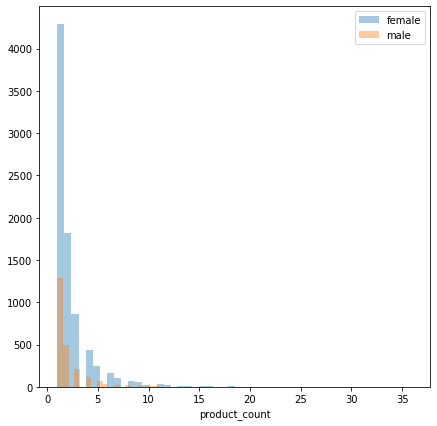

In [80]:
fig,ax = plt.subplots(figsize=(7,7))
sns.distplot(df[df.gender=="female"].product_count,label="female", hist=True,ax=ax,kde=False)
sns.distplot(df[df.gender=="male"].product_count,label="male",hist=True,ax=ax,kde=False)
plt.legend()

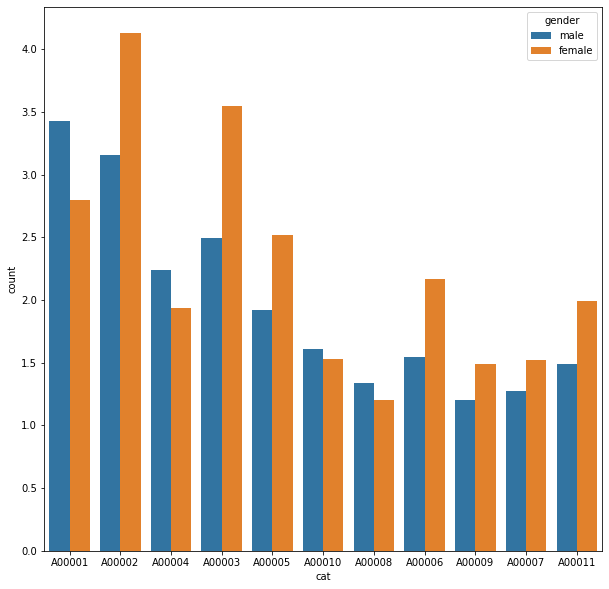

In [195]:
from collections import Counter
c_m = Counter()
c_f = Counter()
for index,rows in df.iterrows():
    if rows["gender"] == "female":
        c_f.update(rows["cat"])
    else:
        c_m.update(rows["cat"])
a = pd.DataFrame(c_m.items())
a["gender"]="male"
a
b = pd.DataFrame(c_f.items())
b["gender"] = "female"
a = pd.concat([a,b],axis=0).rename(columns={0:"cat",1:"count"})
a["count"] = np.log10(a["count"])
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(x="cat",y="count",hue="gender",data=a,ax=ax)

In [209]:
from collections import Counter
c_m = Counter()
c_f = Counter()
for index,rows in df.iterrows():
    a = [f"{i}-{j}"for i , j in zip(rows["cat"],rows["sub-cat"])]
    if rows["gender"] == "female":
        c_f.update(a)
    else:
        c_m.update(a)

In [334]:
for i in set(c_f)-set(c_m):
    print(i , c_f[i])

A00003-B00080 1
A00009-B00075 2
A00009-B00089 1
A00003-B00079 4
A00010-B00072 1
A00005-B00040 9
A00009-B00064 2
A00006-B00061 2
A00003-B00048 5
A00003-B00058 13
A00003-B00008 14
A00010-B00076 7
A00009-B00067 1
A00009-B00073 2
A00003-B00039 41


In [229]:
df_day = df[df.duration_mins<3600]

In [ ]:
# total data points 10500
# 67 data points end_date-start_date > 24 hrs

In [236]:
df_day["month"] = df_day.start_time.dt.month
df_day.head()

,start_time,end_time,product_list,gender,cat,sub-cat,sub-sub-cat,product,product_count,duration_mins,month
0,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,"[A00002, A00002, A00002, A00002]","[B00003, B00003, B00003, B00003]","[C00006, C00006, C00006, C00006]","[D28435, D02554, D28436, D28437]",4,1.0,12
1,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,"[A00001, A00001, A00001, A00001, A00001, A0000...","[B00009, B00009, B00009, B00009, B00009, B0000...","[C00031, C00031, C00031, C00031, C00031, C0003...","[D29404, D02617, D29407, D29410, D29411, D2544...",7,6.0,12
2,2014-12-01 15:58:00,2014-12-01 15:58:00,A00002/B00001/C00020/D16944/,female,[A00002],[B00001],[C00020],[D16944],1,0.0,12
3,2014-11-23 02:57:00,2014-11-23 03:00:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,"[A00002, A00002, A00002]","[B00004, B00004, B00004]","[C00018, C00018, C00018]","[D10284, D10285, D10286]",3,3.0,11
4,2014-12-17 16:44:00,2014-12-17 16:46:00,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,"[A00001, A00001]","[B00001, B00001]","[C00012, C00012]","[D30805, D30806]",2,2.0,12


In [258]:
df_day[df_day.gender=="female"]["start_time"].dt.day_name().value_counts()

Monday       1531
Friday       1503
Saturday     1453
Tuesday      1290
Sunday        918
Wednesday     802
Thursday      650
Name: start_time, dtype: int64

In [259]:
df_day[df_day.gender=="male"]["start_time"].dt.day_name().value_counts()

Monday       426
Friday       407
Sunday       368
Saturday     364
Tuesday      339
Wednesday    237
Thursday     145
Name: start_time, dtype: int64

In [265]:
df_day[df_day.gender=="male"].start_time.dt.is_month_start.value_counts()

False    2226
True       60
Name: start_time, dtype: int64

In [266]:
df_day[df_day.gender=="female"].start_time.dt.is_month_start.value_counts()

False    7858
True      289
Name: start_time, dtype: int64

In [267]:
df_day[df_day.gender=="female"].start_time.dt.weekofyear.value_counts()

51    2027
50    1454
49    1308
48    1166
47    1128
46     760
52     304
Name: start_time, dtype: int64

In [273]:
df_day[df_day.gender=="male"].start_time.dt.weekofyear.value_counts()

51    549
50    397
47    389
49    322
48    299
46    220
52    110
Name: start_time, dtype: int64

In [279]:
df_day[df_day.gender=="male"].start_time.dt.dayofyear.value_counts()

356    110
343     97
330     94
353     91
342     90
352     90
349     86
318     85
351     85
320     83
348     81
321     80
350     80
339     78
341     77
340     74
322     72
329     71
346     70
326     69
327     68
354     64
335     60
347     59
325     56
331     55
355     53
319     52
333     46
323     44
332     27
336     19
337     14
334      6
Name: start_time, dtype: int64

In [277]:
df_day[df_day.gender=="female"].start_time.dt.strftime("%d/%m").value_counts()

06/12    354
18/12    354
08/12    350
16/12    342
14/11    342
09/12    337
17/12    328
15/12    317
22/12    304
13/12    298
19/12    298
27/11    296
12/12    292
01/12    289
17/11    271
26/11    269
07/12    247
25/11    246
18/11    246
15/11    235
05/12    230
20/12    227
28/11    184
16/11    183
22/11    180
14/12    177
21/12    161
29/11    159
21/11    157
23/11    138
19/11    136
02/12    119
03/12     69
30/11     12
Name: start_time, dtype: int64

In [322]:
a = df_day.groupby(pd.Grouper(key = "start_time",freq="6H"))

In [337]:
a.apply(lambda x : x.groupby(by="gender").start_time.count())

start_time           gender
2014-11-14 00:00:00  female     23
                     male        8
2014-11-14 06:00:00  female     99
                     male       26
2014-11-14 12:00:00  female    140
                              ... 
2014-12-22 06:00:00  male       22
2014-12-22 12:00:00  female    125
                     male       30
2014-12-22 18:00:00  female     74
                     male       56
Name: start_time, Length: 260, dtype: int64

In [342]:
df_day["st"] = pd.to_datetime(df_day.start_time.dt.strftime("%H:%M"),format="%H:%M")

In [349]:
df_day.groupby(pd.Grouper(key = "st",freq="H")).apply(lambda x : x.groupby(by="gender").start_time.count())

start_time  end_time  product_list   cat  sub-cat  \
st                  gender                                                      
1900-01-01 00:00:00 female         145       145           145   145      145   
                    male            68        68            68    68       68   
1900-01-01 02:00:00 female          41        41            41    41       41   
                    male            25        25            25    25       25   
1900-01-01 04:00:00 female          50        50            50    50       50   
                    male            27        27            27    27       27   
1900-01-01 06:00:00 female         222       222           222   222      222   
                    male            86        86            86    86       86   
1900-01-01 08:00:00 female        1098      1098          1098  1098     1098   
                    male           195       195           195   195      195   
1900-01-01 10:00:00 female        1233      1233          1233  1233     1233   
                    male           301       301           301   301      301   
1900-01-01 12:00:00 female        1067      1067          1067  1067     1067   
                    male           233       233           233   233      233   
1900-01-01 14:00:00 female        1282      1282          1282  1282     1282   
                    male           278       278           278   278      278   
1900-01-01 16:00:00 female         803       803           803   803      803   
                    male           237       237           237   237      237   
1900-01-01 18:00:00 female         596       596           596   596      596   
                    male           253       253           253   253      253   
1900-01-01 20:00:00 female         969       969           969   969      969   
                    male           377       377           377   377      377   
1900-01-01 22:00:00 female         641       641           641   641      641   
                    male           206       206           206   206      206   

                            sub-sub-cat  product  product_count  \
st                  gender                                        
1900-01-01 00:00:00 female          145      145            145   
                    male             68       68             68   
1900-01-01 02:00:00 female           41       41             41   
                    male             25       25             25   
1900-01-01 04:00:00 female           50       50             50   
                    male             27       27             27   
1900-01-01 06:00:00 female          222      222            222   
                    male             86       86             86   
1900-01-01 08:00:00 female         1098     1098           1098   
                    male            195      195            195   
1900-01-01 10:00:00 female         1233     1233           1233   
                    male            301      301            301   
1900-01-01 12:00:00 female         1067     1067           1067   
                    male            233      233            233   
1900-01-01 14:00:00 female         1282     1282           1282   
                    male            278      278            278   
1900-01-01 16:00:00 female          803      803            803   
                    male            237      237            237   
1900-01-01 18:00:00 female          596      596            596   
                    male            253      253            253   
1900-01-01 20:00:00 female          969      969            969   
                    male            377      377            377   
1900-01-01 22:00:00 female          641      641            641   
                    male            206      206            206   

                            duration_mins  month    st  
st                  gender                              
1900-01-01 00:00:00 female            145    145   145  
       